# Key Objective:  What bills are tabled and refiled over each reach?
## Code from question 1 to determine whether a bill got stuck in commitee.


In [3]:
import pandas as pd
import re

# Load dataset
file_path = "legislation_data.csv"
df = pd.read_csv(file_path)

# Function to extract the first date from the history column
def extract_date(history):
    if pd.isna(history):
        return None
    match = re.search(r"(\d{1,2}/\d{1,2}/\d{4})", history)
    return pd.to_datetime(match.group(1)) if match else None

# Function to determine if a bill progressed beyond committee
def bill_progressed(history):
    if pd.isna(history):
        return False  # No history means we assume it didn't progress
    return not bool(re.search(r"Referred to the committee", history, re.IGNORECASE))

# Function to extract the date of passage
def extract_passage_date(history):
    if pd.isna(history):
        return None
    match = re.findall(r"(\d{1,2}/\d{1,2}/\d{4})", history)
    return pd.to_datetime(match[-1]) if match else None

# Apply functions
df["assigned_date"] = df["history"].apply(extract_date)
df["progressed"] = df["history"].apply(bill_progressed)
df["passage_date"] = df["history"].apply(extract_passage_date)

# Calculate days taken for bills to pass
df["days_to_pass"] = (df["passage_date"] - df["assigned_date"]).dt.days

# Remove rows where assigned_date or days_to_pass is None
df = df.dropna(subset=["assigned_date", "days_to_pass"])
df.head()

,file_path,bill_number,bill_title,bill_url,sponsor_name,sponsor_url,scraped_date,cosponsors,num_cosponsors,history,assigned_date,progressed,passage_date,days_to_pass
0,/Users/johanchua/Desktop/Stats 141XP Desktop/d...,H.4147,An Act providing technical education and econo...,https://malegislature.gov/Bills/192/H4147,"Harrington, Sheila C.",https://malegislature.gov/Legislators/Profile/...,2025-01-04,"Lindsay N. Sabadosa, Mathew J. Muratore, Micha...",3.0,9/30/2021: House - Referred to the committee o...,2021-09-30,False,2022-09-01,336.0
1,/Users/johanchua/Desktop/Stats 141XP Desktop/d...,S.1263,An Act relative to recovery homes,https://malegislature.gov/Bills/192/S1263,"Collins, Nick",https://malegislature.gov/Legislators/Profile/...,2025-01-04,NaN,0.0,3/29/2021: Senate - Referred to the committee ...,2021-03-29,False,2022-09-22,542.0
2,/Users/johanchua/Desktop/Stats 141XP Desktop/d...,H.3682,An Act amending the Medal of Liberty,https://malegislature.gov/Bills/192/H3682,"Murray, Brian W.",https://malegislature.gov/Legislators/Profile/...,2025-01-04,"Michael J. Soter, Jeffrey N. Roy, Colleen M. G...",7.0,3/29/2021: House - Referred to the committee o...,2021-03-29,False,2022-08-25,514.0
3,/Users/johanchua/Desktop/Stats 141XP Desktop/d...,SD.3464,DVS Veteran Advisory Committee Interim Report,https://malegislature.gov/Bills/192/SD3464,NaN,NaN,2025-01-04,NaN,0.0,1/3/2023: Senate - Placed on file,2023-01-03,True,2023-01-03,0.0
4,/Users/johanchua/Desktop/Stats 141XP Desktop/d...,H.2990,An Act to encourage Massachusetts residency,https://malegislature.gov/Bills/192/H2990,"Livingstone, Jay D.",https://malegislature.gov/Legislators/Profile/...,2025-01-04,Carlos González,1.0,3/29/2021: House - Referred to the committee o...,2021-03-29,False,2022-07-11,469.0


Clean up data and only keep relevant columns

In [4]:
df = df[['bill_title', 'progressed']]
df['progressed'] = df["progressed"].astype(int)
df.head()

<ipython-input-4-e523d0d68dc1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['progressed'] = df["progressed"].astype(int)


,bill_title,progressed
0,An Act providing technical education and econo...,0
1,An Act relative to recovery homes,0
2,An Act amending the Medal of Liberty,0
3,DVS Veteran Advisory Committee Interim Report,1
4,An Act to encourage Massachusetts residency,0


Naive Bayes Classification Model

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['bill_title'])
y = df['progressed']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9230352303523035


Extract information from the model to analyze bill titles

In [6]:
import numpy as np

# Get feature names (words from the vectorizer)
feature_names = vectorizer.get_feature_names_out()

# Get log probabilities for each class (0 = failed, 1 = passed)
log_probabilities = model.feature_log_prob_

# Find the top words associated with each class
top_n = 30  # Number of words to display

# Words most indicative of a passed bill
top_passed_indices = np.argsort(log_probabilities[1])[-top_n:][::-1]
top_passed_words = [feature_names[i] for i in top_passed_indices]

# Words most indicative of a failed bill
top_failed_indices = np.argsort(log_probabilities[0])[-top_n:][::-1]
top_failed_words = [feature_names[i] for i in top_failed_indices]

print("Top words in bills that progress:")
print(top_passed_words)

print("\nTop words in bills that get stuck in commitee:")
print(top_failed_words)


Top words in bills that progress:
['of', 'the', 'to', 'an', 'act', 'and', 'report', 'from', 'chapter', 'relative', 'communication', 'for', 'section', 'submitting', 'general', 'laws', 'department', 'health', 'see', 'public', 'acts', 'office', 'under', 'annual', 'in', 'its', 'on', 'inspection', 'massachusetts', 'correction']

Top words in bills that get stuck in commitee:
['an', 'act', 'to', 'the', 'of', 'relative', 'and', 'for', 'in', 'certain', 'town', 'establishing', 'authorizing', 'on', 'public', 'health', 'massachusetts', 'commonwealth', 'tax', 'providing', 'by', 'care', 'study', 'from', 'order', 'city', 'department', 'commission', 'safety', 'state']


Visualization of important words and probabilities

<ipython-input-7-468cf1392f53>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_passed_probs, y=top_passed_words, ax=axes[0], palette="Greens_r")
<ipython-input-7-468cf1392f53>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_failed_probs, y=top_failed_words, ax=axes[1], palette="Reds_r")


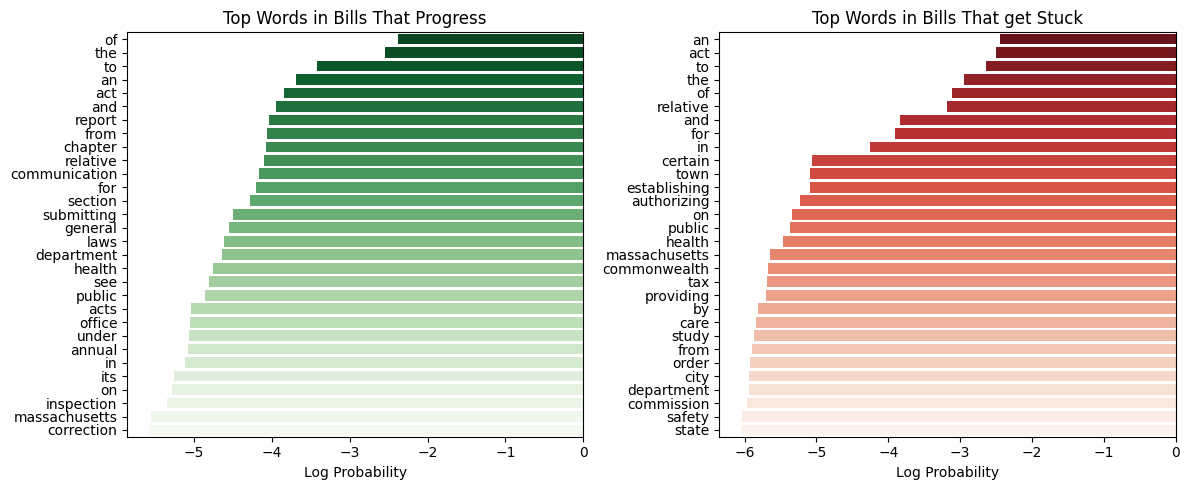

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of words to display
top_n = 30

# Get the top words and their corresponding probabilities
top_passed_probs = [log_probabilities[1][i] for i in top_passed_indices]
top_failed_probs = [log_probabilities[0][i] for i in top_failed_indices]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Passed Bills - Bar Chart
sns.barplot(x=top_passed_probs, y=top_passed_words, ax=axes[0], palette="Greens_r")
axes[0].set_title("Top Words in Bills That Progress")
axes[0].set_xlabel("Log Probability")

# Failed Bills - Bar Chart
sns.barplot(x=top_failed_probs, y=top_failed_words, ax=axes[1], palette="Reds_r")
axes[1].set_title("Top Words in Bills That get Stuck")
axes[1].set_xlabel("Log Probability")

plt.tight_layout()
plt.show()


The Multinomial Naive Bayes did pretty well with a 92% accuracy. However, since naive bayes assumes word independence, we got words that aren't very meaningful in this context as most important such as "of", "the", "to", and "and."

Let's try a random forest/logistic regression approach using TF-IDF

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

X = df['bill_title']
y = df['progressed']

# Convert bill titles into TF-IDF features
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Limit to 5000 features for efficiency
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_model.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# # Train a Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Predict on test data
# y_pred_rf = rf_model.predict(X_test)

# # Evaluate Random Forest model
# print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
# print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Logistic Regression Accuracy: 0.9254742547425474
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      9173
           1       0.97      0.58      0.73      1897

    accuracy                           0.93     11070
   macro avg       0.95      0.79      0.84     11070
weighted avg       0.93      0.93      0.92     11070



In [9]:
import numpy as np

# Get feature names (words from TF-IDF)
feature_names = vectorizer.get_feature_names_out()

# Get logistic regression coefficients
coefficients = log_model.coef_[0]

# Sort words by importance
top_n = 10
top_passed_indices = np.argsort(coefficients)[-top_n:][::-1]  # Most positive words (passed)
top_failed_indices = np.argsort(coefficients)[:top_n]  # Most negative words (failed)

print("Top words in bills that PASS:", [feature_names[i] for i in top_passed_indices])
print("Top words in bills that FAIL:", [feature_names[i] for i in top_failed_indices])


Top words in bills that PASS: ['report', 'communication', 'amendment', 'submitting', 'inspection', 'house', 'senate', 'correction', '2022', 'section']
Top words in bills that FAIL: ['act', 'extension', 'resolve', 'investigation', 'make', 'environmental', 'ensuring', 'establishing', 'coverage', 'establish']


<ipython-input-13-b02736b4770d>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_passed_values, y=top_passed_words, ax=axes[0], palette="Greens_r")
<ipython-input-13-b02736b4770d>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_failed_values, y=top_failed_words, ax=axes[1], palette="Reds_r")


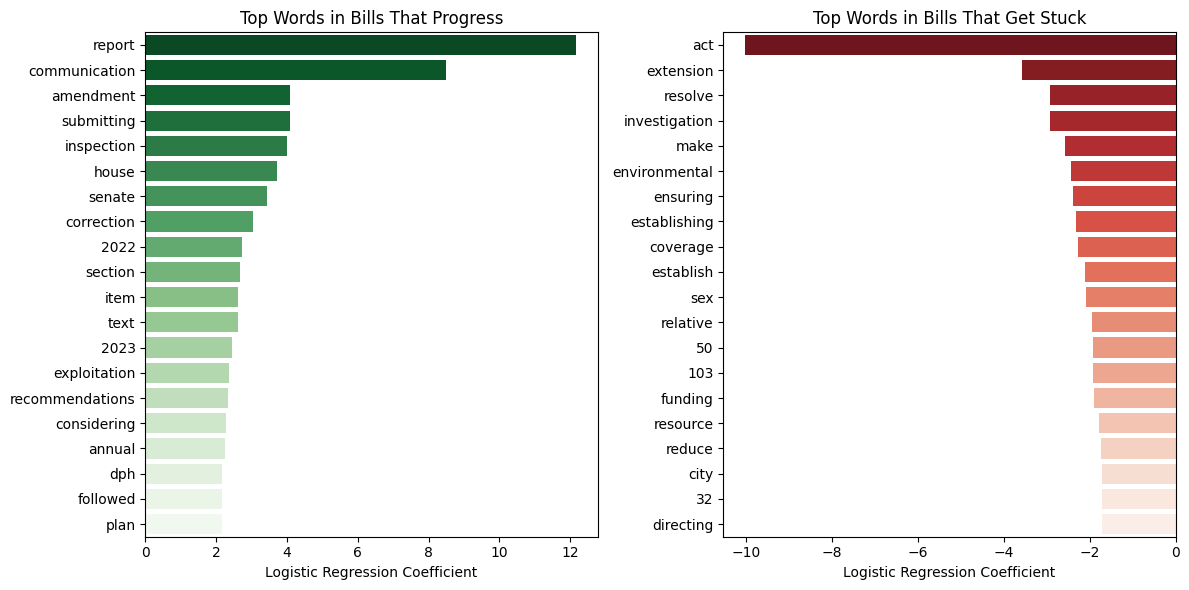

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Get logistic regression coefficients
coefficients = log_model.coef_[0]

# Select top words that contribute to passing and failing
top_n = 20
top_passed_indices = np.argsort(coefficients)[-top_n:][::-1]  # Highest positive weights (indicative of passing)
top_failed_indices = np.argsort(coefficients)[:top_n]         # Lowest negative weights (indicative of failing)

# Get corresponding words
top_passed_words = [feature_names[i] for i in top_passed_indices]
top_failed_words = [feature_names[i] for i in top_failed_indices]

# Get their corresponding coefficient values
top_passed_values = coefficients[top_passed_indices]
top_failed_values = coefficients[top_failed_indices]


# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot words most indicative of passing bills
sns.barplot(x=top_passed_values, y=top_passed_words, ax=axes[0], palette="Greens_r")
axes[0].set_title("Top Words in Bills That Progress")
axes[0].set_xlabel("Logistic Regression Coefficient")

# Plot words most indicative of failing bills
sns.barplot(x=top_failed_values, y=top_failed_words, ax=axes[1], palette="Reds_r")
axes[1].set_title("Top Words in Bills That Get Stuck")
axes[1].set_xlabel("Logistic Regression Coefficient")

plt.tight_layout()
plt.show()


## XGBoost

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


# Convert TF-IDF matrix to a dense format (XGBoost doesn't support sparse matrices directly)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_dense, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_dense)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9269196025293587
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      9173
           1       0.99      0.58      0.73      1897

    accuracy                           0.93     11070
   macro avg       0.96      0.79      0.84     11070
weighted avg       0.93      0.93      0.92     11070



<ipython-input-14-e875c7dd1254>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[top_indices], y=[feature_names[i] for i in top_indices], palette="Blues_r")


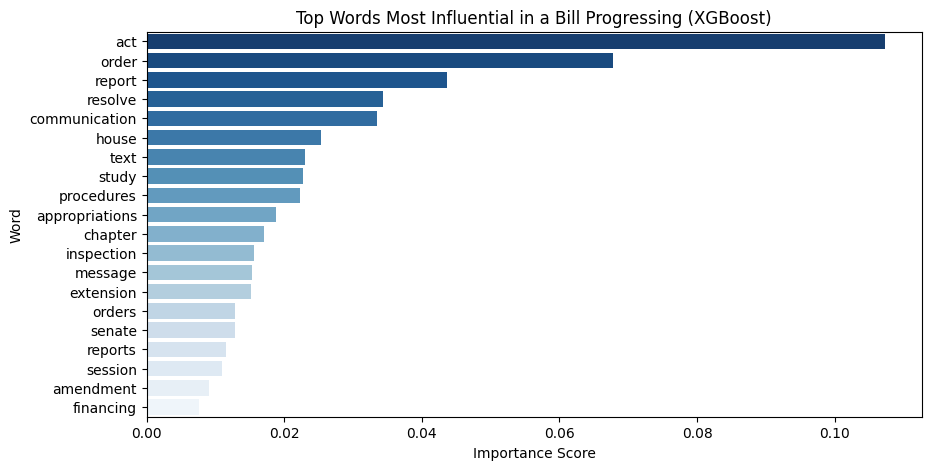

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from XGBoost
feature_importance = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort top words
top_n = 20
top_indices = np.argsort(feature_importance)[-top_n:][::-1]  # Get top 10 words

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance[top_indices], y=[feature_names[i] for i in top_indices], palette="Blues_r")
plt.xlabel("Importance Score")
plt.ylabel("Word")
plt.title("Top Words Most Influential in a Bill Progressing (XGBoost)")
plt.show()
